In [2]:
from rdkit.Chem import PandasTools
from rdkit import Chem
import prolif as plf
from rdkit import DataStructs
import seaborn as sns
import pandas as pd

In [3]:
query_df = PandasTools.LoadSDF("queries_97.sdf")

In [4]:
query_df = query_df[['ID','ROMol']]

In [5]:
query_df.columns = ['Query','ROMol']

In [6]:
pick_df = PandasTools.LoadSDF("picks_min.sdf")

/Users/pwalters/miniconda3/envs/rdkit_2023_05/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,ID,idx,name,init_energy,final_energy,rms,Query,ROMol
0,5439040_12529118,0,5439040_12529118,130.770596,-39.649301,0.900786,5RT7_5RST,
1,11353774_13812584,2,11353774_13812584,105.351369,-20.415948,0.928868,5RT7_5RST,
2,5439040_15082468,3,5439040_15082468,118.426738,-49.833348,0.910969,5RT7_5RST,
3,10719886_13242790,6,10719886_13242790,55.592621,-92.810402,1.496553,5RTA_5RV1,
4,15106796_14927978,7,15106796_14927978,55.592621,-92.810402,1.496553,5RTA_5RV1,
...,...,...,...,...,...,...,...,...
1434,18961462_18922924_15859308,6538,18961462_18922924_15859308,2675.143413,-12.561964,1.301131,5S1E_5RTV,
1435,14076256_14104614,6545,14076256_14104614,1020.351052,-23.675541,0.839428,5S1E_5RTV,
1436,14085654_14106358,6547,14085654_14106358,618132.381444,-41.214575,1.202614,5S1E_5RTV,
1437,14076256_14093906,6550,14076256_14093906,2680.387996,-17.306831,1.222159,5S1E_5RTV,

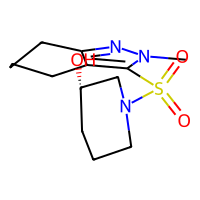
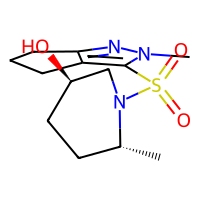
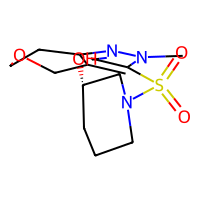
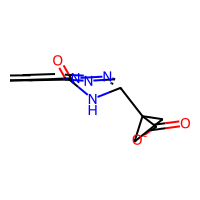
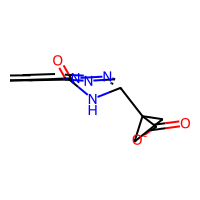
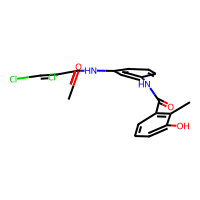
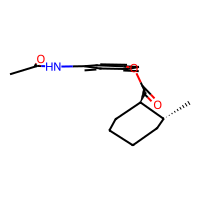
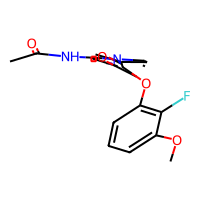
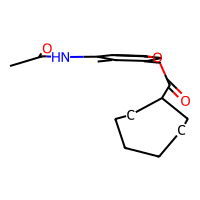
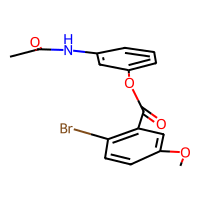

In [7]:
pick_df

In [8]:
df = pd.concat([query_df,pick_df])

In [9]:
props = [x for x in df.columns if x != 'ROMol']

In [10]:
PandasTools.WriteSDF(df,"combined.sdf",properties=props)

In [13]:
PDB_FILEPATH = "5RSG_aligned_protein.pdb"
SDF_FILEPATH = "combined.sdf"

In [14]:
fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(SDF_FILEPATH)
fp.run_from_iterable(suppl,prot,progress=True)
df = fp.to_dataframe()
df.columns = df.columns.droplevel(0)

  0%|          | 0/1536 [00:00<?, ?it/s]

In [15]:
bv = fp.to_bitvectors()
len(bv)

1536

In [16]:
query_df['fp'] = bv[0:len(query_df)]

In [17]:
pick_df['fp'] = bv[len(query_df):]

In [18]:
pick_df.columns

Index(['ID', 'idx', 'name', 'init_energy', 'final_energy', 'rms', 'Query',
       'ROMol', 'fp'],
      dtype='object')

In [19]:
query_fp_dict = dict([(a,b) for a,b in query_df[['Query','fp']].values])

In [20]:
tv_sim_list = []
for row_num in range(0,len(pick_df)):
    query = pick_df.iloc[row_num].Query
    query_fp = query_fp_dict[query]
    pick_fp = pick_df.iloc[row_num].fp
    tv_sim = DataStructs.TverskySimilarity(query_fp,pick_fp,1,0)
    tv_sim_list.append(tv_sim)

In [21]:
pick_df['tv_sim'] = tv_sim_list

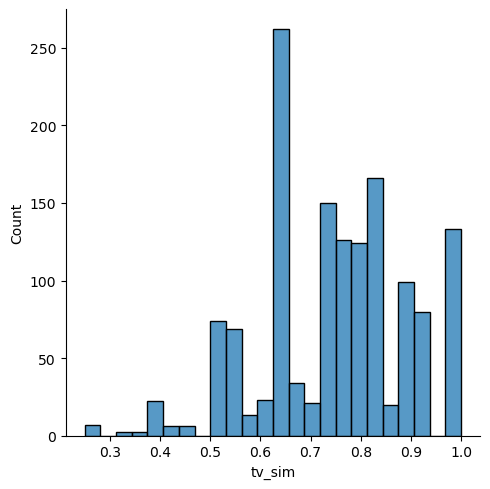

In [22]:
sns.displot(pick_df.tv_sim)

In [23]:
pick_df.shape

(1439, 10)

In [24]:
pick_df.query("tv_sim >= 0.9").shape

(218, 10)

In [25]:
props = [x for x in pick_df.columns if x != 'ROMol']
PandasTools.WriteSDF(pick_df.query("tv_sim >= 0.9"),out="Enamine_REAL_Selections.sdf",properties=props)

In [26]:
pick_df.rms = pick_df.rms.astype(float)

<Axes: xlabel='rms', ylabel='tv_sim'>

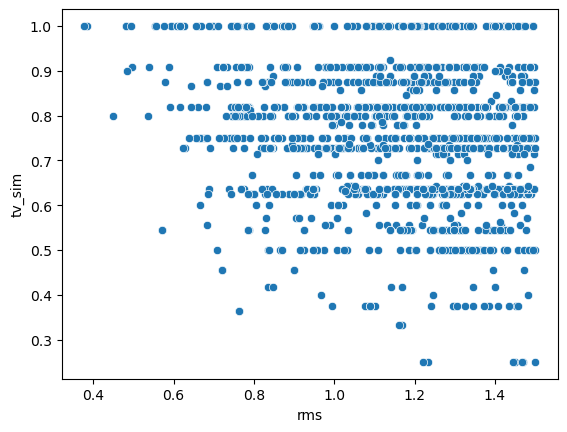

In [27]:
sns.scatterplot(x=pick_df.rms,y=pick_df.tv_sim)

In [28]:
row_0 = pick_df.query('tv_sim < 0.5').iloc[0]
hit_mol = row_0.ROMol
query_name = row_0.Query
row_0

ID                                              17649684_11730220
idx                                                           115
name                                            17649684_11730220
init_energy                                            425.965803
final_energy                                            -4.373271
rms                                                      1.141964
Query                                                   5RSW_5RUR
ROMol               <rdkit.Chem.rdchem.Mol object at 0x303e89000>
fp              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...
tv_sim                                                   0.416667
Name: 41, dtype: object

In [29]:
query_mol = query_df.query("Query == @query_name").ROMol.values[0]

In [30]:
writer = Chem.SDWriter("compare2.sdf")
writer.write(query_mol)
writer.write(hit_mol)
writer.close()